In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import sys
import random

from skimage.io import imread, imshow
from skimage.transform import resize

from skimage import feature

from skimage.filters import sobel
from skimage.morphology import watershed

from skimage import morphology

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
from torch.autograd import Variable

from torchvision import transforms as tf



from pathlib import Path
import nibabel as nib
from sklearn import preprocessing
from skimage import transform

# from tqdm import tqdm

from imgaug import augmenters as iaa

from utils.display_utils import image_grid, image_gray
from utils.neuron_dataset import Neuron_dataset
from networks.Unet_no_z_pool import Unet
from utils.trainer import train_loop

In [2]:
path = 'data/'

In [3]:
img = imread(path+'train-input.tif')
# label = imread('new_labels_.tif')
label3 = imread(path+'new_labels_3x3_f.tif')
label2 = imread(path+'new_labels_2x2_f.tif')
(img.shape, label3.shape, label2.shape)

((100, 1024, 1024), (100, 1024, 1024), (100, 1024, 1024))

In [4]:
img =np.rollaxis(img, 0,3)
label2 = np.rollaxis(label2,0,3)
label3= np.rollaxis(label3,0,3)

In [5]:
img.shape, label2.shape, label3.shape

((1024, 1024, 100), (1024, 1024, 100), (1024, 1024, 100))

<Figure size 432x288 with 0 Axes>

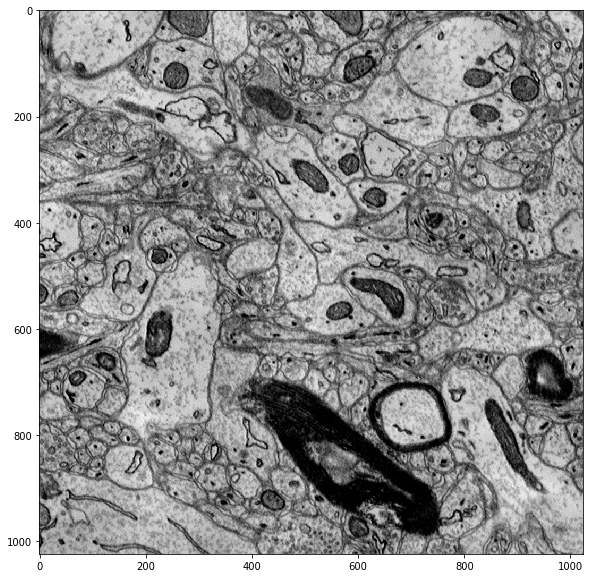

In [6]:
image_gray(img[:,:,99])

In [7]:

train_l = 10000
val_l = 2000
dim_z = 6
dim_x = 64
dim_y = 64
X_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_train = np.zeros((train_l, dim_x, dim_y, dim_z), dtype=np.float32)

X_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)
Y_val = np.zeros((val_l, dim_x, dim_y, dim_z), dtype=np.float32)


In [8]:
#top 80
half = 32
for i in range(0,10000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(3,77)
    
    label_pick = np.random.randint(2)
    X_train[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick==0:
        Y_train[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_train[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]

#bottom 20
for i in range(0,2000):
    x = np.random.randint(half,1024-half)
    y = np.random.randint(half,1024-half)
    z = np.random.randint(83,97)
   
    label_pick = np.random.randint(2)
    X_val[i] = img[x-half:x+half,y-half:y+half,z-3:z+3]
    if label_pick ==0:
        Y_val[i] = label2[x-half:x+half,y-half:y+half,z-3:z+3]
    else:
        Y_val[i] = label3[x-half:x+half,y-half:y+half,z-3:z+3]
    
X_train = X_train/255
X_val = X_val/255

In [9]:
neuron_dataset_train = Neuron_dataset(X_train, 
                                      train=True, 
                                      masks=Y_train,
                                      transform=True)

neuron_dataset_val = Neuron_dataset(X_val, 
                                      train=True, 
                                      masks=Y_val,
                                      transform=False)

batch_size = 64

train_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_train, 
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=neuron_dataset_val, 
                                           batch_size=batch_size, 
                                           shuffle=True)



<Figure size 432x288 with 0 Axes>

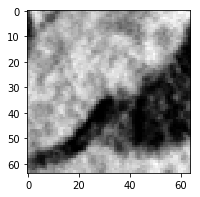

torch.Size([64, 64, 6])


In [10]:
get_it = next(iter(train_loader))
im = get_it[0][0].squeeze()
image_gray(im[:,:,4],3)
print(im.shape)

In [11]:
im=get_it[0]
im.shape

torch.Size([64, 1, 64, 64, 6])

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [13]:
model = Unet()
model.to(device)

Unet(
  (down1): Conv_block(
    (conv1): Sequential(
      (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down2): Conv_block(
    (conv1): Sequential(
      (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): Sequential(
      (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (1): ReLU()
      (2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down3): Conv_block(
    (conv1): S

In [14]:
criterion = nn.BCEWithLogitsLoss()
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=.1)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, 
                                                 milestones=[100,200,400,500], gamma=0.1)



In [ ]:
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

Active CUDA Device: GPU 0
Available devices  4
Current cuda device  0


EPOCH:  1
Training loss:....... 0.7105596589434678
Validation loss:..... 0.6698395013809204
NEW BEST Loss: 0.6698395013809204 ........old best:99999

inside


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


<Figure size 432x288 with 0 Axes>

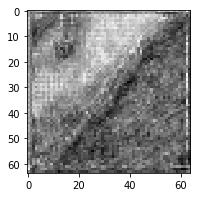

<Figure size 432x288 with 0 Axes>

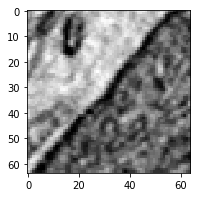


EPOCH:  2
Training loss:....... 0.6381485746924285
Validation loss:..... 0.6362737528979778
NEW BEST Loss: 0.6362737528979778 ........old best:0.6698395013809204


EPOCH:  3


In [ ]:
save_bst = 'experiments/jan21_64_pool/best.pth'
save_last = 'experiments/jan21_64_pool/last_1000.pth'
hist = train_loop(train_loader,val_loader,im, model,optimizer,scheduler,criterion,
                 save_bst,save_last)